### Import required libraries

In [6]:
import os

from glob import glob
from itertools import chain

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [7]:
% matplotlib inline

In [8]:
FILTER_PA = False

### Load data

In [9]:
data_dir = 'data'
_dir = data_dir + '/' + 'Data_Entry_2017.csv'

all_df = pd.read_csv(_dir)

all_paths = {os.path.basename(x): x for x in 
             glob(os.path.join(data_dir, 'images', '*.png'))}
             # glob(os.path.join(data_dir, 'images*', '*', '*.png'))}
    
print('Labels found:', all_df.shape[0])
print('Scans found:', len(all_paths))

Labels found: 112120
Scans found: 112120


In [10]:
# Filter by PA view only

if FILTER_PA:
    all_df['View Position'].value_counts()
    all_df = all_df[all_df['View Position'] == 'PA']

In [11]:
all_df['path'] = all_df['Image Index'].map(all_paths.get)
all_df.sample

<bound method NDFrame.sample of              Image Index                                Finding Labels  \
0       00000001_000.png                                  Cardiomegaly   
1       00000001_001.png                        Cardiomegaly|Emphysema   
2       00000001_002.png                         Cardiomegaly|Effusion   
3       00000002_000.png                                    No Finding   
4       00000003_000.png                                        Hernia   
5       00000003_001.png                                        Hernia   
6       00000003_002.png                                        Hernia   
7       00000003_003.png                           Hernia|Infiltration   
8       00000003_004.png                                        Hernia   
9       00000003_005.png                                        Hernia   
10      00000003_006.png                                        Hernia   
11      00000003_007.png                                        Hernia   
12    

### Preprocess labels

In [12]:
label_counts = all_df['Finding Labels'].value_counts()

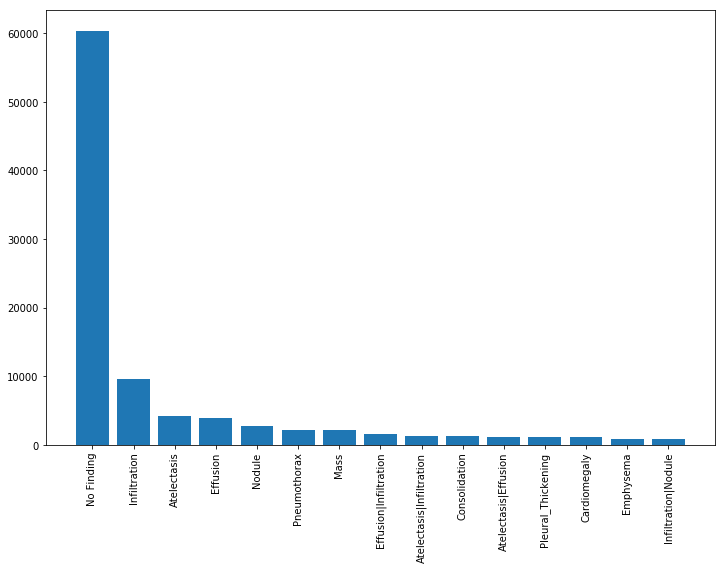

In [13]:
# Label counts

fig, ax1 = plt.subplots(1, 1, figsize = (12, 8))
ax1.bar(np.arange(len(label_counts[:15])) + 0.5, label_counts[:15])
ax1.set_xticks(np.arange(len(label_counts[:15])) + 0.5)
_ = ax1.set_xticklabels(label_counts[:15].index, rotation = 90)

In [14]:
followup_counts = all_df['Follow-up #'].value_counts()

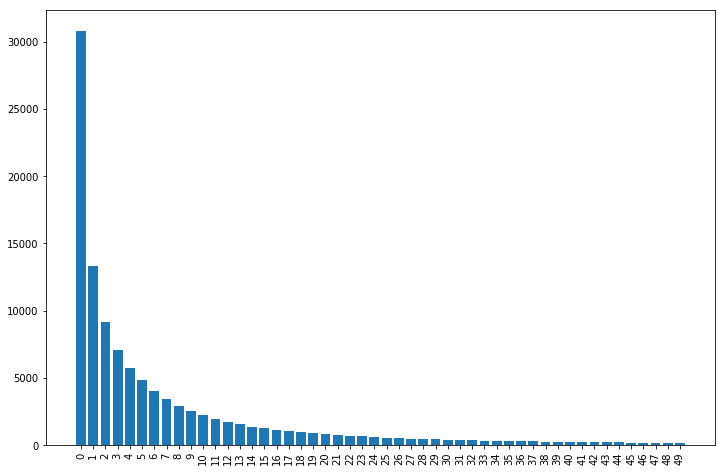

In [15]:
# Follow-up counts

fig, ax1 = plt.subplots(1, 1, figsize = (12, 8))
ax1.bar(np.arange(len(followup_counts[:50])) + 0.5, followup_counts[:50])
ax1.set_xticks(np.arange(len(followup_counts[:50])) + 0.5)
_ = ax1.set_xticklabels(followup_counts[:50].index, rotation = 90)

In [16]:
all_df['Finding Labels'] = all_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

all_labels = np.unique(list(chain(*all_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [17]:
for label in all_labels:
    if len(label) > 1: # leave out empty labels
        all_df[label] = all_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
        
all_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
50367,00012750_002.png,Atelectasis|Pneumonia,2,12750,66,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
112025,00030740_000.png,,0,30740,23,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94140,00023940_000.png,,0,23940,50,F,PA,2614,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26084,00006850_023.png,Cardiomegaly,23,6850,57,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73052,00017994_006.png,Mass|Pneumothorax,6,17994,60,F,PA,2638,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### All conditions

In [74]:
first_df = all_df[all_df['Follow-up #'] == 0]

In [75]:
sample_weights = all_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x) > 0 else 0).values + 4e-4
sample_weights /= sample_weights.sum()

all_df_sample = all_df.sample(20000, weights=sample_weights)

In [55]:
sample_weights = first_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x) > 0 else 0).values + 4e-4
sample_weights /= sample_weights.sum()

first_df_sample = first_df.sample(20000, weights=sample_weights)

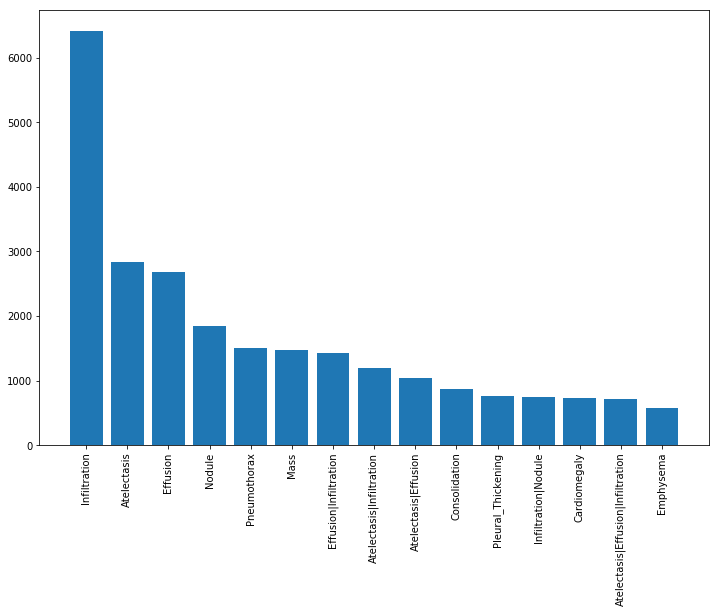

In [56]:
# After sampling out negative cases

label_counts = all_df_sample['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1, 1, figsize = (12, 8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

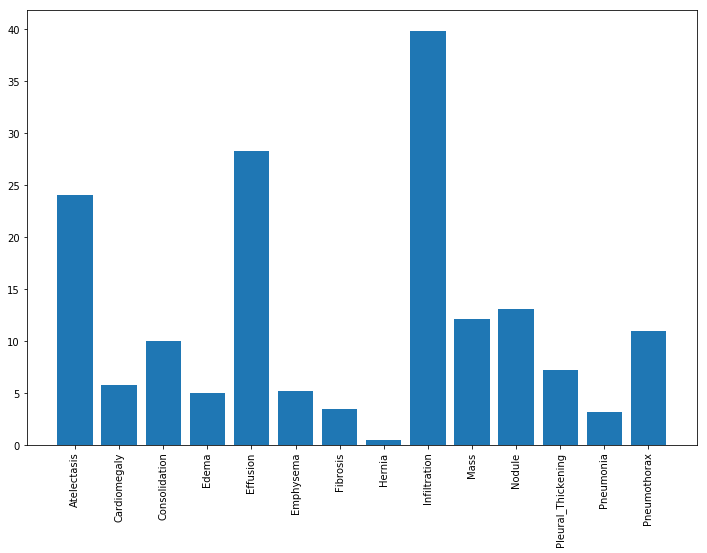

In [57]:
# Adjusted frequency

label_counts = 100 * np.mean(all_df_sample[all_labels].values, 0)
fig, ax1 = plt.subplots(1, 1, figsize = (12, 8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
_ = ax1.set_xticklabels(all_labels, rotation = 90)

### Singular pneumothorax

In [18]:
first_df = all_df[all_df['Follow-up #'] == 0]

In [19]:
singular_df_pneumothorax = first_df[first_df['Finding Labels'] == 'Pneumothorax']
singular_df_pneumothorax.sample(5)

singular_df_pneumothorax_neg = first_df[first_df['Finding Labels'] == '']
singular_df_pneumothorax_neg = singular_df_pneumothorax_neg.sample(singular_df_pneumothorax.shape[0])
singular_df_pneumothorax_neg.sample(5)

singular_df_pneumothorax_neg.shape, singular_df_pneumothorax_neg.shape

((109, 27), (109, 27))

### First pneumothorax

In [20]:
# for i in first_df_nothing_sample['path']:
#     plt.imshow(mpimg.imread(i))
#     plt.show()

In [21]:
first_df_pneumothorax = first_df[first_df['Pneumothorax'] == 1]
first_df_pneumothorax.sample(5)

first_df_pneumothorax_neg = first_df[first_df['Finding Labels'] == '']
first_df_pneumothorax_neg = first_df_pneumothorax_neg.sample(first_df_pneumothorax.shape[0])
first_df_pneumothorax_neg.sample(5)

first_df_pneumothorax_neg.shape, first_df_pneumothorax_neg.shape

((186, 27), (186, 27))

### All pneumothorax

In [22]:
all_df_pneumothorax = all_df[all_df['Pneumothorax'] == 1]
all_df_pneumothorax.sample(5)

all_df_pneumothorax_neg = all_df[all_df['Finding Labels'] == '']
all_df_pneumothorax_neg = all_df_pneumothorax_neg.sample(all_df_pneumothorax.shape[0])
all_df_pneumothorax_neg.sample(5)

all_df_pneumothorax_neg.shape, all_df_pneumothorax_neg.shape

((3407, 27), (3407, 27))

### Unique pneumothorax 

In [23]:
unique_df_pneumothorax = all_df[all_df['Finding Labels'] == 'Pneumothorax']
unique_df_pneumothorax.sample(5)

unique_df_pneumothorax_neg = all_df[all_df['Finding Labels'] == '']
unique_df_pneumothorax_neg = unique_df_pneumothorax_neg.sample(unique_df_pneumothorax.shape[0])
unique_df_pneumothorax_neg.sample(5)

unique_df_pneumothorax_neg.shape, unique_df_pneumothorax_neg.shape

((1506, 27), (1506, 27))

### Singular cardiomegaly

In [24]:
singular_df_cardiomegaly = first_df[first_df['Finding Labels'] == 'Cardiomegaly']
singular_df_cardiomegaly.sample(5)

singular_df_cardiomegaly_neg = first_df[first_df['Finding Labels'] == '']
singular_df_cardiomegaly_neg = singular_df_cardiomegaly_neg.sample(singular_df_cardiomegaly.shape[0])
singular_df_cardiomegaly_neg.sample(5)

singular_df_cardiomegaly_neg.shape, singular_df_cardiomegaly_neg.shape

((411, 27), (411, 27))

### First cardiomegaly

In [25]:
first_df_cardiomegaly = first_df[first_df['Cardiomegaly'] == 1]
first_df_cardiomegaly.sample(5)

first_df_cardiomegaly_neg = first_df[first_df['Finding Labels'] == '']
first_df_cardiomegaly_neg = first_df_cardiomegaly_neg.sample(first_df_cardiomegaly.shape[0])
first_df_cardiomegaly_neg.sample(5)

first_df_cardiomegaly_neg.shape, first_df_cardiomegaly_neg.shape

((673, 27), (673, 27))

### All cardiomegaly

In [26]:
all_df_cardiomegaly = all_df[all_df['Cardiomegaly'] == 1]
all_df_cardiomegaly.sample(5)

all_df_cardiomegaly_neg = all_df[all_df['Finding Labels'] == '']
all_df_cardiomegaly_neg = all_df_cardiomegaly_neg.sample(all_df_cardiomegaly.shape[0])
all_df_cardiomegaly_neg.sample(5)

all_df_cardiomegaly_neg.shape, all_df_cardiomegaly_neg.shape

((1563, 27), (1563, 27))

### Unique cardiomegaly

In [27]:
unique_df_cardiomegaly = all_df[all_df['Finding Labels'] == 'Cardiomegaly']
unique_df_cardiomegaly.sample(5)

unique_df_cardiomegaly_neg = all_df[all_df['Finding Labels'] == '']
unique_df_cardiomegaly_neg = unique_df_cardiomegaly_neg.sample(unique_df_cardiomegaly.shape[0])
unique_df_cardiomegaly_neg.sample(5)

unique_df_cardiomegaly_neg.shape, unique_df_cardiomegaly_neg.shape

((746, 27), (746, 27))

### Make labels

In [18]:
_dir = data_dir + '/split/' + 'df.csv'
all_df.to_csv(_dir, index=None)

In [76]:
_dir = data_dir + '/split/' + 'all_df.csv'
all_df_sample.to_csv(_dir, index=None)

In [59]:
_dir = data_dir + '/split/' + 'first_df.csv'
first_df_sample.to_csv(_dir, index=None)

In [33]:
df = pd.concat([singular_df_pneumothorax, singular_df_pneumothorax_neg])

_dir = data_dir + '/split/' + 'singular_df_pneumothorax.csv'
df.to_csv(_dir, index=None)

In [34]:
df = pd.concat([first_df_pneumothorax, first_df_pneumothorax_neg])

_dir = data_dir + '/split/' + 'first_df_pneumothorax.csv'
df.to_csv(_dir, index=None)

In [35]:
df = pd.concat([all_df_pneumothorax, all_df_pneumothorax_neg])

_dir = data_dir + '/split/' + 'all_df_pneumothorax.csv'
df.to_csv(_dir, index=None)

In [36]:
df = pd.concat([unique_df_pneumothorax, unique_df_pneumothorax_neg])

_dir = data_dir + '/split/' + 'unique_df_pneumothorax.csv'
df.to_csv(_dir, index=None)

In [37]:
df = pd.concat([singular_df_cardiomegaly, singular_df_cardiomegaly_neg])

_dir = data_dir + '/split/' + 'singular_df_cardiomegaly.csv'
df.to_csv(_dir, index=None)

In [38]:
df = pd.concat([first_df_cardiomegaly, first_df_cardiomegaly_neg])

_dir = data_dir + '/split/' + 'first_df_cardiomegaly.csv'
df.to_csv(_dir, index=None)

In [39]:
df = pd.concat([all_df_cardiomegaly, all_df_cardiomegaly_neg])

_dir = data_dir + '/split/' + 'all_df_cardiomegaly.csv'
df.to_csv(_dir, index=None)

In [40]:
df = pd.concat([unique_df_cardiomegaly, unique_df_cardiomegaly_neg])

_dir = data_dir + '/split/' + 'unique_df_cardiomegaly.csv'
df.to_csv(_dir, index=None)